In [1]:
!pip install statsmodels
!pip install seaborn

Initial Data:
        Control_1  Control_2  Treatment_1  Treatment_2
Gene                                                  
BRCA1         520        510          700          690
TP53          180        175          210          205
EGFR          350        340          500          510
MYC           620        610          740          730
PIK3CA        400        410          480          490
AKT1          210        220          190          180
PTEN          500        510          550          560
KRAS          600        590          650          640
NRAS          320        310          300          290
CDK2          410        405          500          495

Differential Expression Results:
     Gene   Log2_FC  Fold_Change   P-value  Adj_P-value
0   BRCA1  0.431747     1.348866  0.001621     0.007047
1    TP53  0.224161     1.168098  0.013791     0.022986
2    EGFR  0.548446     1.462509  0.002114     0.007047
3     MYC  0.256790     1.194817  0.003518     0.008794
4  PIK3CA  0

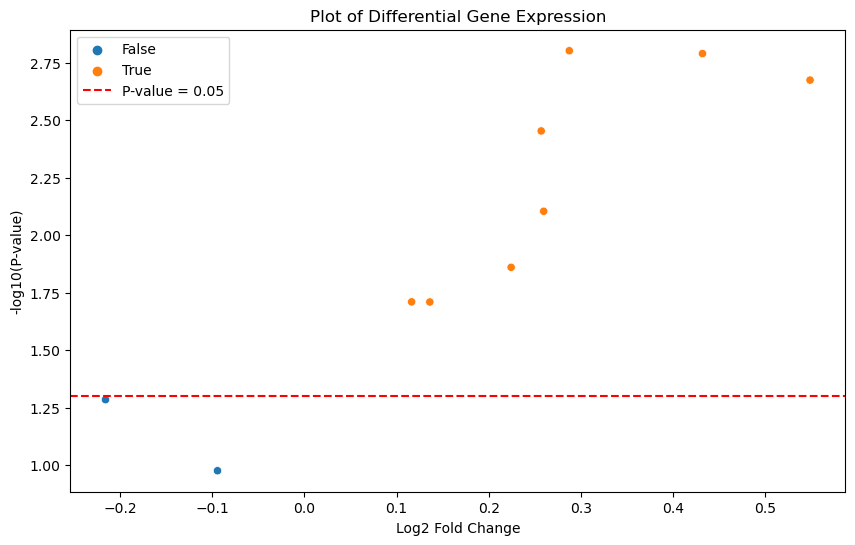

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# Example RNA-Seq data (replace with actual dataset)
data = {
    'Gene': ['BRCA1', 'TP53', 'EGFR', 'MYC', 'PIK3CA', 'AKT1', 'PTEN', 'KRAS', 'NRAS', 'CDK2'],
    'Control_1': [520, 180, 350, 620, 400, 210, 500, 600, 320, 410],
    'Control_2': [510, 175, 340, 610, 410, 220, 510, 590, 310, 405],
    'Treatment_1': [700, 210, 500, 740, 480, 190, 550, 650, 300, 500],
    'Treatment_2': [690, 205, 510, 730, 490, 180, 560, 640, 290, 495]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)
df.set_index('Gene', inplace=True)

print("Initial Data:")
print(df)

# Define conditions (4 samples: 2 control, 2 treatment)
conditions = ['Control', 'Control', 'Treatment', 'Treatment']

# Log2 transform to stabilize variance
df_log = np.log2(df + 1)

# Differential Expression Analysis
results = []

for gene in df_log.index:
    # Response variable (gene expression values)
    y = df_log.loc[gene].values.astype(float)

    # Independent variable (condition: 0=Control, 1=Treatment)
    X = pd.get_dummies(conditions, drop_first=True).astype(float)

    # Add intercept
    X = sm.add_constant(X)

    # Fit OLS model
    model = sm.OLS(y, X).fit()

    # Extract fold change and p-value
    # Using .iloc to access by position to resolve the FutureWarning
    log2_fc = model.params.iloc[1]  # coefficient = log2 fold change
    fold_change = 2 ** log2_fc  # convert back to linear scale
    p_value = model.pvalues.iloc[1]

    results.append([gene, log2_fc, fold_change, p_value])

# Store results
results_df = pd.DataFrame(results, columns=['Gene', 'Log2_FC', 'Fold_Change', 'P-value'])

# Multiple testing correction (FDR)
results_df['Adj_P-value'] = multipletests(results_df['P-value'], method='fdr_bh')[1]

print("\nDifferential Expression Results:")
print(results_df)

# Volcano plot with Log2 Fold Change on the x-axis
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='Log2_FC', y=-np.log10(results_df['P-value']), hue=results_df['Adj_P-value'] < 0.05)

plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='P-value = 0.05')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(P-value)')
plt.title('Plot of Differential Gene Expression')
plt.legend()
plt.show()